In [3]:
import pandas as pd
weather_extreme = pd.read_csv(r"C:\Users\dmarc\Desktop\EWELD_Energy_project\data\processed\weather_extreme.csv")
weather_data = pd.read_csv(r"C:\Users\dmarc\Desktop\EWELD_Energy_project\data\processed\weather_data.csv")

In [12]:
# Convert 'Times' column to datetime
weather_extreme['Start Time'] = pd.to_datetime(weather_extreme['Start Time'])
weather_extreme['End Time'] = pd.to_datetime(weather_extreme['End Time'])
weather_data['Time'] = pd.to_datetime(weather_data['Time'])

In [16]:
weather_extreme['Extreme Weather'].value_counts().to_frame('Count')

,Count
Extreme Weather,
High humidty,2095
High temperature,1897
Low temperature,625
High heat and humidty,292
Heavy T-Storm,273
Heavy Rain Shower,204
Tropical Storm,85
Heavy T-Storm with Windy,73
Severe Tropical Storm,63


In [4]:
#Fill null values in key columns with defaults
weather_extreme_clean = weather_extreme.copy()
print(f"Shape weather_extreme: {weather_extreme_clean.shape}\n")
# For City column - drop rows with null cities (can't merge without city)
weather_extreme_clean = weather_extreme_clean.dropna(subset=['City'])
print("Null values after cleaning:")
print(weather_extreme_clean[['City', 'Date', 'Extreme Weather', 'EWno']].isnull().sum())
print(f"\nShape weather_extreme_clean: {weather_extreme_clean.shape}")


Shape weather_extreme: (5741, 6)

Null values after cleaning:
City               0
Date               0
Extreme Weather    0
EWno               0
dtype: int64

Shape weather_extreme_clean: (5741, 6)


### weather_data

In [5]:
# weather_data dataframe Overview
print("Weather Data Overview:")
print(f"Total rows: {len(weather_data)}")
print(f"Time range: {weather_data['Time'].min()} to {weather_data['Time'].max()}")
print(f"Cities: {weather_data['City'].nunique()} unique cities")

print("\nExtreme Weather Data Overview:")
print(f"Total extreme events: {len(weather_extreme)}")
print(f"Time range: {weather_extreme['Start Time'].min()} to {weather_extreme['End Time'].max()}")
print(f"Cities with extremes: {weather_extreme['City'].nunique()} unique cities")
print("\nSample extreme events:")
print(weather_extreme[['City', 'Start Time', 'End Time', 'Extreme Weather']].head())

Weather Data Overview:
Total rows: 824253
Time range: 2015-01-01 00:00:00 to 2022-11-01 23:30:00
Cities: 3 unique cities

Extreme Weather Data Overview:
Total extreme events: 5741
Time range: 2015-01-01 00:30:00 to 2022-11-03 05:00:00
Cities with extremes: 3 unique cities

Sample extreme events:
  City           Start Time             End Time Extreme Weather
0  CT1  2016-07-10 00:00:00  2016-07-10 02:00:00  Tropical Storm
1  CT1  2016-08-02 10:00:00  2016-08-02 22:00:00  Tropical Storm
2  CT1  2016-08-18 05:00:00  2016-08-18 21:00:00  Tropical Storm
3  CT1  2016-09-15 10:00:00  2016-09-15 15:00:00  Tropical Storm
4  CT1  2016-09-28 11:00:00  2016-09-28 22:00:00  Tropical Storm


### Correlations Between Extreme Weather (TropicalStorm) and Weather Parameters

In [6]:
# Initialize 'Is_TropicalStorm' column with 0 (no tropical storm)
weather_data['Is_TropicalStorm'] = 0

# Filter only 'Tropical Storm' events (redundant here, but good practice)
tropical_storms = weather_extreme[weather_extreme['Extreme Weather'] == 'Tropical Storm']

# Mark time ranges where Tropical Storms occurred
for _, row in tropical_storms.iterrows():
    mask = (
        (weather_data['Time'] >= row['Start Time']) & 
        (weather_data['Time'] <= row['End Time'])
    )
    weather_data.loc[mask, 'Is_TropicalStorm'] = 1  # Flag as Tropical Storm

In [7]:
# Verify some flagged periods
storm_samples = weather_data[weather_data['Is_TropicalStorm'] == 1].sample(3)
print(storm_samples[['Time', 'Wind Speed(mph)', 'Is_TropicalStorm']])

                       Time  Wind Speed(mph)  Is_TropicalStorm
62109   2016-10-08 23:15:00            13.12                 1
740616  2020-06-13 18:30:00            11.89                 1
231201  2021-08-05 08:15:00             3.96                 1


In [8]:
# Analyze Correlations for Tropical Storms - Mean Comparison
tropical_stats = weather_data.groupby('Is_TropicalStorm')[
    ['Temperature(C)','Wind Speed(mph)', 'Pressure(hPa)', 'Humidity(%)']
].mean()
print(tropical_stats)

                  Temperature(C)  Wind Speed(mph)  Pressure(hPa)  Humidity(%)
Is_TropicalStorm                                                             
0                      23.745439         8.171429    1010.334162    76.703555
1                      27.367255        12.639249    1000.136457    82.816526


Because Tropical Storm (EW08) is acc to clasyfication cryteria  wind speed larger than 39 mph and smaller than 54 mph additional Wind Speed Filtering implemanted

In [9]:
# Count how many flagged periods meet Tropical Storm criteria
true_storms = weather_data[
    (weather_data['Is_TropicalStorm'] == 1) & 
    (weather_data['Wind Speed(mph)'] >= 39) &
    (weather_data['Wind Speed(mph)'] <= 54)
]

print(f"True Tropical Storms: {len(true_storms)}/{weather_data['Is_TropicalStorm'].sum()} periods meet wind criteria")

True Tropical Storms: 93/7887 periods meet wind criteria


In [10]:
# Classify periods more accurately
weather_data['True_TropicalStorm'] = 0
weather_data.loc[
    (weather_data['Is_TropicalStorm'] == 1) & 
    (weather_data['Wind Speed(mph)'] >= 39),
    'True_TropicalStorm'
] = 1

# Get improved statistics
revised_stats = weather_data.groupby('True_TropicalStorm')[
    ['Wind Speed(mph)', 'Pressure(hPa)', 'Humidity(%)']
].agg(['mean', 'min', 'max'])
revised_stats

Wind Speed(mph)               Pressure(hPa)          \
                              mean    min    max          mean     min   
True_TropicalStorm                                                       
0                         8.207704   0.00  40.44   1010.241234  963.09   
1                        48.950992  39.04  72.93    980.980153  954.28   

                            Humidity(%)                 
                        max        mean    min     max  
True_TropicalStorm                                      
0                   1058.25   76.759217  11.96  102.00  
1                   1009.48   94.574351  78.20  101.87

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns  

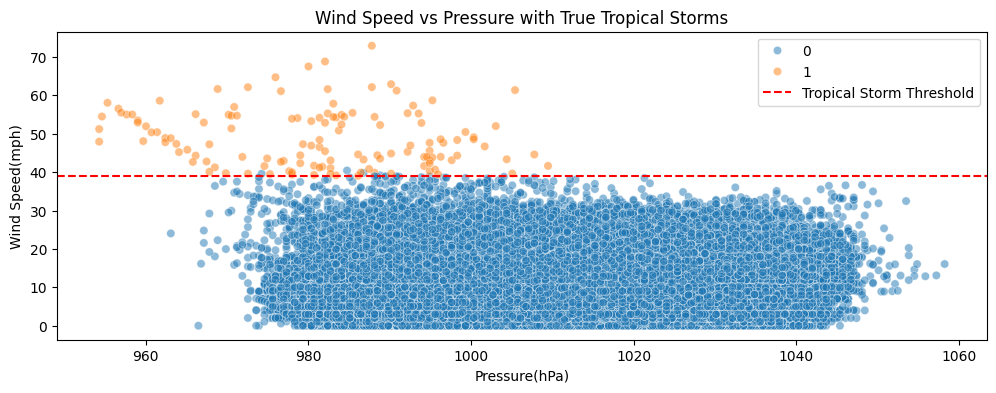

In [12]:
plt.figure(figsize=(12,4))
sns.scatterplot(
    x='Pressure(hPa)', 
    y='Wind Speed(mph)', 
    hue='True_TropicalStorm', 
    data=weather_data,
    alpha=0.5
)
plt.axhline(y=39, color='red', linestyle='--', label='Tropical Storm Threshold')
plt.title('Wind Speed vs Pressure with True Tropical Storms')
plt.legend()
plt.show()